In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Heat transfer function (simulated true function)
def heat_transfer_loss(x1, x2, x3, delta_T=100, k1=1.0, k2=0.5, L3=0.05):
    Q = delta_T / ((x1/k1) + (x2/k2) + (L3/x3))
    return Q

In [5]:
# Generate training data
n_samples = 1000
x1 = torch.rand(n_samples, 1) * 0.09 + 0.01  # Random values between 0.01 and 0.1
x2 = torch.rand(n_samples, 1) * 0.09 + 0.01  # Random values between 0.01 and 0.1
x3 = torch.rand(n_samples, 1) * 4.9 + 0.1    # Random values between 0.1 and 5.0

Q = heat_transfer_loss(x1, x2, x3)

# Combine inputs into a single tensor
inputs = torch.cat((x1, x2, x3), dim=1)
outputs = Q.view(-1, 1)


In [13]:
class SurrogateModel(nn.Module):
    def __init__(self):
        super(SurrogateModel, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
# Initialize the model
model = SurrogateModel()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

# Train the model and record the loss for each epoch
loss_history = []

# Training loop
n_epochs = 40000
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(inputs)
    loss = criterion(predictions, outputs)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Record the loss
    loss_history.append(loss.item())
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')


Epoch [500/40000], Loss: 2148.7786
Epoch [1000/40000], Loss: 870.2504
Epoch [1500/40000], Loss: 573.4305
Epoch [2000/40000], Loss: 447.3875
Epoch [2500/40000], Loss: 480.4555
Epoch [3000/40000], Loss: 352.6682
Epoch [3500/40000], Loss: 337.3008
Epoch [4000/40000], Loss: 319.2349
Epoch [4500/40000], Loss: 310.9847
Epoch [5000/40000], Loss: 346.0301
Epoch [5500/40000], Loss: 320.4490
Epoch [6000/40000], Loss: 323.1336
Epoch [6500/40000], Loss: 314.7343
Epoch [7000/40000], Loss: 306.0161
Epoch [7500/40000], Loss: 335.1163
Epoch [8000/40000], Loss: 327.7735
Epoch [8500/40000], Loss: 348.6819
Epoch [9000/40000], Loss: 303.5571
Epoch [9500/40000], Loss: 317.0231
Epoch [10000/40000], Loss: 322.8290
Epoch [10500/40000], Loss: 299.3707
Epoch [11000/40000], Loss: 313.7759
Epoch [11500/40000], Loss: 332.0701
Epoch [12000/40000], Loss: 328.7594
Epoch [12500/40000], Loss: 311.5294
Epoch [13000/40000], Loss: 368.3563
Epoch [13500/40000], Loss: 290.7946
Epoch [14000/40000], Loss: 246.4918
Epoch [1450

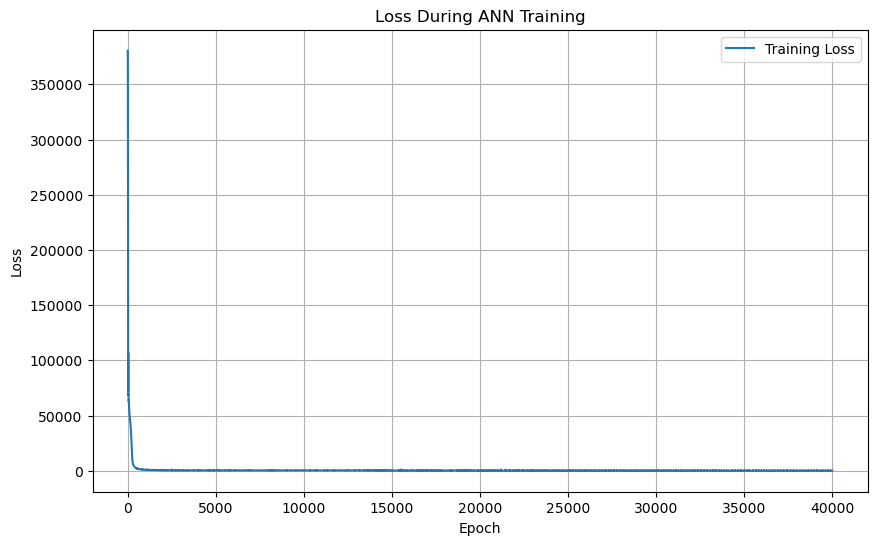

In [19]:
# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss During ANN Training')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Initial guess for optimization
x_opt = torch.tensor([0.05, 0.05, 2.5], requires_grad=True)

# Optimizer for the optimization process
optimizer = optim.Adam([x_opt], lr=0.01)

# Optimization loop
n_iterations = 500
for iteration in range(n_iterations):
    optimizer.zero_grad()
    
    # Predict the heat loss using the surrogate model
    Q_pred = model(x_opt)
    
    # Since we want to minimize Q, we use Q_pred as the loss
    Q_pred.backward()
    optimizer.step()
    
    if (iteration + 1) % 50 == 0:
        print(f'Iteration [{iteration+1}/{n_iterations}], Predicted Q: {Q_pred.item():.4f}, x_opt: {x_opt.data.numpy()}')

# Final optimized values
print(f'Optimized x1, x2, x3: {x_opt.data.numpy()}')


Iteration [50/500], Predicted Q: -120.1575, x_opt: [0.37935638 0.35152012 1.9989929 ]
Iteration [100/500], Predicted Q: -520.4503, x_opt: [0.63262767 0.65234375 1.4112861 ]
Iteration [150/500], Predicted Q: -700.7047, x_opt: [0.8643519 0.8749326 1.2890058]
Iteration [200/500], Predicted Q: -864.5883, x_opt: [1.1097434 1.0750371 1.6692   ]
Iteration [250/500], Predicted Q: -1045.1124, x_opt: [1.3822894 1.3011627 2.038328 ]
Iteration [300/500], Predicted Q: -1240.5980, x_opt: [1.6759583 1.5461358 2.4443493]
Iteration [350/500], Predicted Q: -1448.8495, x_opt: [1.9876168 1.8075897 2.8783944]
Iteration [400/500], Predicted Q: -1668.1268, x_opt: [2.314861  2.0835137 3.33493  ]
Iteration [450/500], Predicted Q: -1897.1243, x_opt: [2.655535  2.3722425 3.8119717]
Iteration [500/500], Predicted Q: -2134.7004, x_opt: [3.0079658 2.6722684 4.307686 ]
Optimized x1, x2, x3: [3.0079658 2.6722684 4.307686 ]
